<h1>Brain Tumor image Visualization and Classification (MRI)</h1>

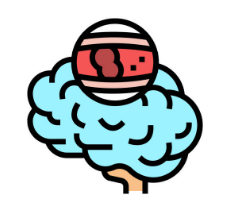

<h3>Content</h3>

- Brain Tumor types
- Library
- Loading the dataset
- Data analysis
- Image visualisation
- Image preprocessing
- Modelling

<h2>Brain Tumor types</h2>

<h3>Glioma Tumor</h3>

A glioma is a type of brain tumor that starts from glial cells, which are cells that surround and support nerve cells in the brain and spinal cord. There are different types of gliomas, such as astrocytoma, glioblastoma, oligodendroglioma and ependymoma. Some gliomas are benign, which means they do not spread to other parts of the body. Others are malignant, which means they grow quickly and invade healthy tissue. Gliomas can cause various symptoms depending on where they are located in the brain or spinal cord, such as headaches, nausea, confusion, memory loss, vision problems, speech difficulties and seizures. Gliomas can affect people of any age, but they are more common in adults than in children. The treatment options for gliomas may include surgery, radiation therapy, chemotherapy and other therapies.

<h3>Meningioma Tumor</h3>

Meningioma is a type of brain tumor that starts from the meninges, the membranes that cover the brain and spinal cord. Meningiomas are usually benign, which means they do not spread to other parts of the body, but they can cause symptoms such as headaches, vision problems, seizures and memory loss. Meningiomas are the most common type of tumor that forms in the head and affect more women than men. The treatment options for meningiomas may include surgery, radiation therapy or watchful waiting.

<h3>Pituitary Tumor</h3>

A pituitary brain tumor is a type of tumor that develops in the pituitary gland, which is a small organ at the base of the brain that produces various hormones. A pituitary brain tumor is not technically a brain tumor, because the pituitary gland is not part of the brain, but it is close to it. Pituitary brain tumors can be benign or malignant, meaning they can be noncancerous or cancerous. Most pituitary brain tumors are benign and do not spread to other parts of the body. Pituitary brain tumors can cause different symptoms depending on their size and the type of hormones they produce. Some of the symptoms may include headaches, vision problems, nausea, fatigue, mood changes, infertility and sexual dysfunction.. Pituitary brain tumors can be diagnosed by blood tests, urine tests, MRI scans, CT scans and vision test.

<h2>Libraries</h2>

In [30]:
import os
import cv2
import glob
import random
import imageio
import time 
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import skimage.measure   
import tensorflow as tf
from skimage import data
import albumentations as A
import scipy.ndimage as ndi
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from skimage.measure.entropy import shannon_entropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization




<h2>Data analysis</h2>

<h3>Image dataset creation</h3>

In [31]:
train_data_path = '/kaggle/input/brain-tumor-classification-mri/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [32]:
train_df

,filepaths,label
0,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
1,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
2,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
3,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
4,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
...,...,...
2865,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2866,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2867,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2868,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  2870 non-null   object
 1   label      2870 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB


In [34]:
test_data_path = '/kaggle/input/brain-tumor-classification-mri/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [35]:
test_df

,filepaths,label
0,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
1,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
2,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
3,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
4,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
...,...,...
389,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
390,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
391,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
392,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  394 non-null    object
 1   label      394 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB


<h3>Split dataset</h3>

In [37]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

<h3>Image resize and generation</h3>

In [38]:
img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


<h2>Modelling</h2>

In [2]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' , input_shape = img_shape, pooling= 'max')

model_op1 = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_op1.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_op1.summary()

NameError: name 'train_gen' is not defined

<h3>Model training</h3>

In [13]:
Epochs = 8
start_time = time.time()
history_op1 = model_op1.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/8


2024-03-31 15:04:15.903972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 108s 215ms/step - loss: 7.1769 - accuracy: 0.7843 - val_loss: 6.8672 - val_accuracy: 0.6041
Epoch 2/8
192/192 [==============================] - 37s 194ms/step - loss: 4.7177 - accuracy: 0.9150 - val_loss: 4.9238 - val_accuracy: 0.6345
Epoch 3/8
192/192 [==============================] - 37s 193ms/step - loss: 3.2615 - accuracy: 0.9564 - val_loss: 3.4279 - val_accuracy: 0.7259
Epoch 4/8
192/192 [==============================] - 37s 193ms/step - loss: 2.2648 - accuracy: 0.9718 - val_loss: 2.4215 - val_accuracy: 0.7868
Epoch 5/8
192/192 [==============================] - 37s 193ms/step - loss: 1.5655 - accuracy: 0.9801 - val_loss: 1.9405 - val_accuracy: 0.7716
Epoch 6/8
192/192 [==============================] - 37s 194ms/step - loss: 1.0927 - accuracy: 0.9868 - val_loss: 1.6058 - val_accuracy: 0.7462
Epoch 7/8
192/192 [==============================] - 37s 193ms/step - loss: 0.8048 - accuracy: 0.9826 - val_loss: 1.4383 - val_accuracy: 0.7766
E

In [14]:
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

Total length of process: 6.130715954303741 minutes


In [39]:
base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=img_shape, alpha=1.0, depth_multiplier=1)
for layer in base_model.layers:
    layer.trainable = False

In [40]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 110, 110, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 110, 110, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 110, 110, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 110, 110, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 110, 110, 32)     128       
 ation)                                         

# MobileNet V3 

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 6, 6, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 36864)             0         
                                                                 
 dense_20 (Dense)            (None, 256)               9437440   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 12,667,332
Trainable params: 9,438,468
No

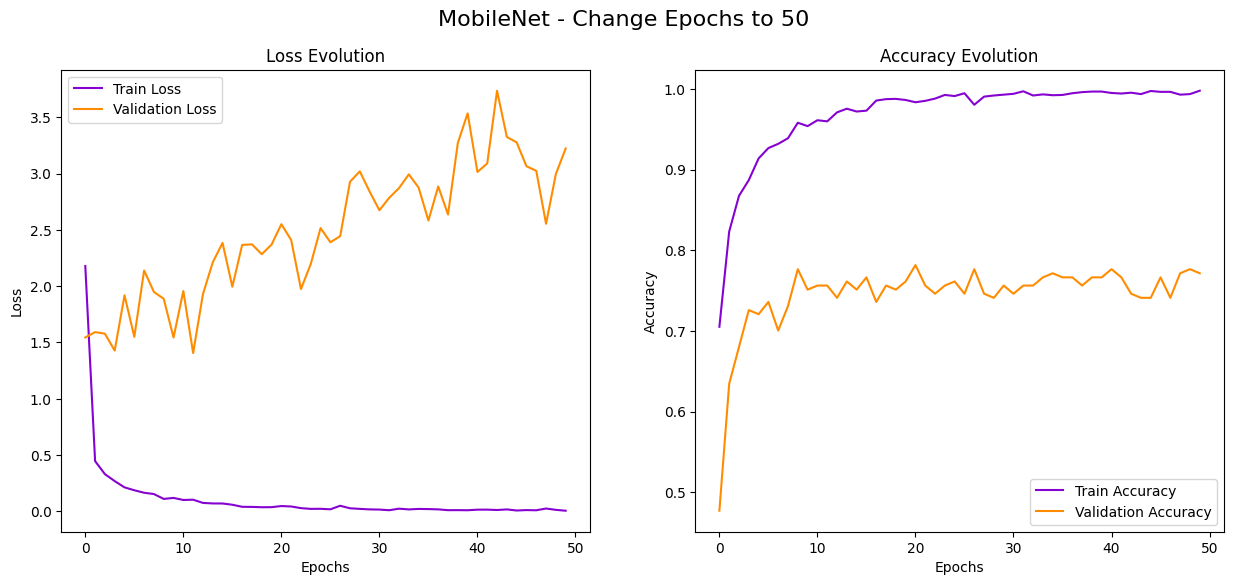

In [33]:
from keras.applications import MobileNet

gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_size = (img_size[0], img_size[1])
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)


base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=img_shape, alpha=1.0, depth_multiplier=1)
for layer in base_model.layers:
    layer.trainable = False

model_mobilenet = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model_mobilenet.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

# Model training
Epochs = 50
start_time = time.time()
history_mobilenet = model_mobilenet.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                                        validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_mobilenet = history_mobilenet.history
val_loss_mobilenet = history_dict_mobilenet['val_loss']
train_loss_mobilenet = history_dict_mobilenet['loss']
val_accuracy_mobilenet = history_dict_mobilenet['val_accuracy']
train_accuracy_mobilenet = history_dict_mobilenet['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_mobilenet, label='Train Loss', color='#8502d1')
plt.plot(val_loss_mobilenet, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_mobilenet, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_mobilenet, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('MobileNet - Change Epochs to 50', fontsize=16)

plt.show()

In [25]:
base_model = keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=img_shape, alpha=1.0, depth_multiplier=1)
for layer in base_model.layers:
    layer.trainable = False

model_mobilenet = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

model_mobilenet.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 6, 6, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               9437440   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 12,667,332
Trainable params: 9,438,468
Non-

In [26]:
model_mobilenet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 6, 6, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               9437440   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 12,667,332
Trainable params: 9,438,468
Non-trainable params: 3,228,864
_____________________________________

# VGG-16 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               4718848   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 19,434,564
Trainable params: 4,719,876
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
192/192 [==============

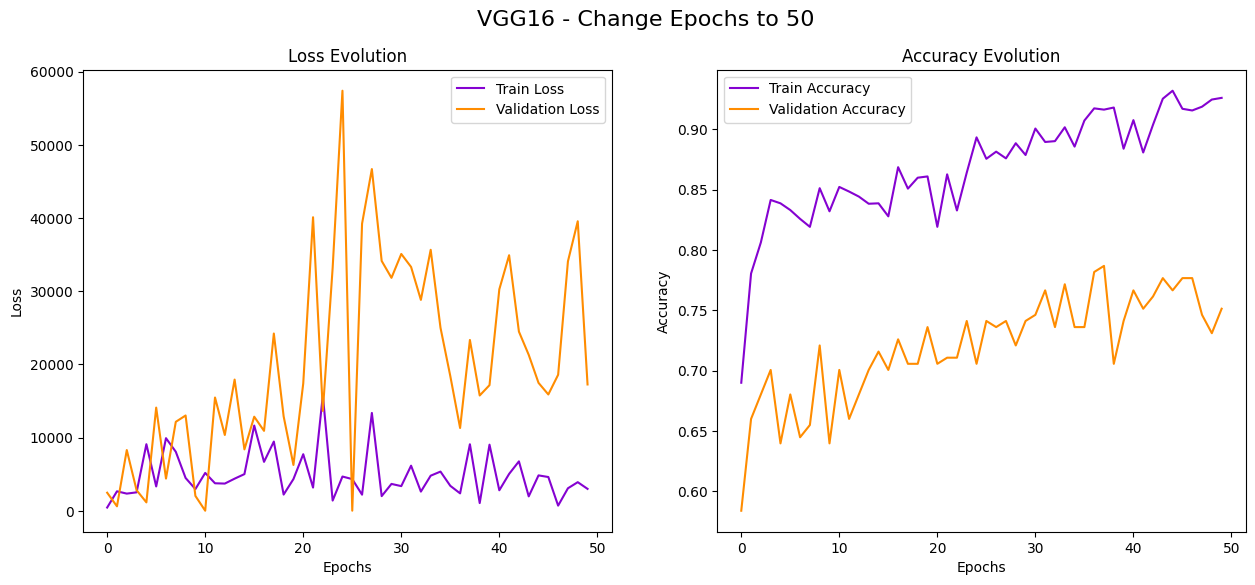

In [20]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_size = (img_size[0], img_size[1])
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)


base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
for layers in base_model.layers:
        layers.trainable=False
        
model_vgg16 = Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    Dense(256, activation='relu'),  # Adjusted number of units
    Dropout(rate=0.4, seed=75),  # Adjusted dropout rate
    Dense(num_class, activation='softmax')
])

# Compiling the model
model_vgg16.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

# Model training
Epochs = 50
start_time = time.time()
history_vgg16 = model_vgg16.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                                validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_vgg16 = history_vgg16.history
val_loss_vgg16 = history_dict_vgg16['val_loss']
train_loss_vgg16 = history_dict_vgg16['loss']
val_accuracy_vgg16 = history_dict_vgg16['val_accuracy']
train_accuracy_vgg16 = history_dict_vgg16['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_vgg16, label='Train Loss', color='#8502d1')
plt.plot(val_loss_vgg16, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_vgg16, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_vgg16, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('VGG16 - Change Epochs to 50', fontsize=16)

plt.show()


In [41]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
for layers in base_model.layers:
        layers.trainable=False

In [42]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 220, 220, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 220, 220, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 110, 110, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 110, 110, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 110, 110, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 55, 55, 128)       0     

# VGG16 Second Try

In [12]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

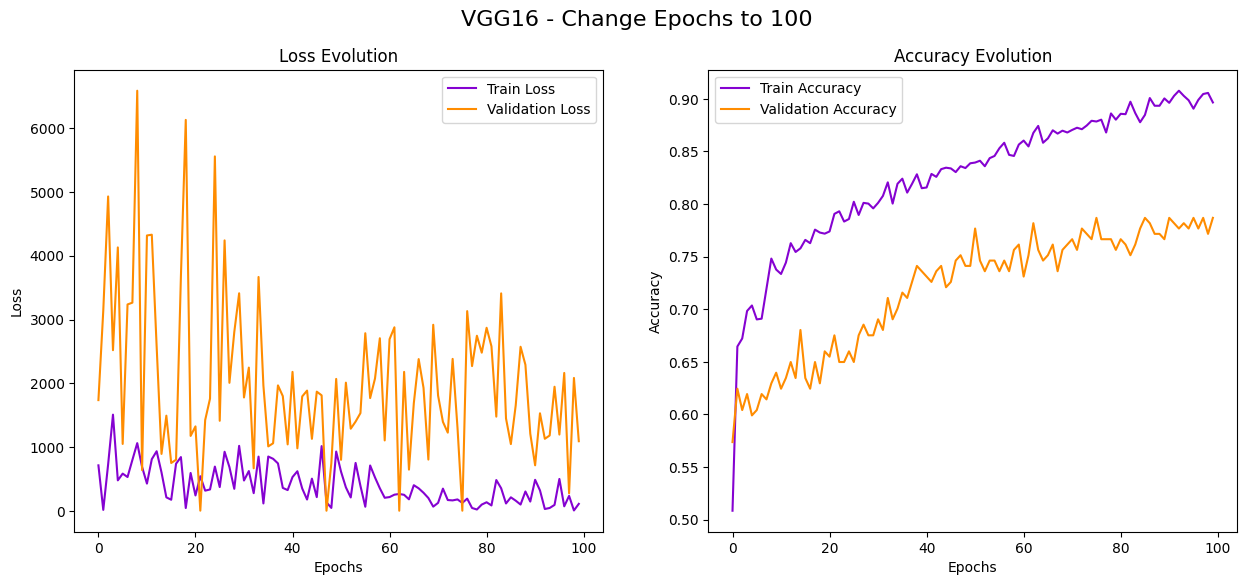

In [15]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_size = (img_size[0], img_size[1])
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)


vgg_model_01 = VGG16(weights='imagenet', include_top=False)
for layer in vgg_model_01.layers:
    layer.trainable = False

x = vgg_model_01.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=vgg_model_01.input, outputs=output)
model_vgg.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

# Model training
Epochs = 100
start_time = time.time()
history_vgg16 = model_vgg.fit(train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                           validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_vgg16 = history_vgg16.history
val_loss_vgg16 = history_dict_vgg16['val_loss']
train_loss_vgg16 = history_dict_vgg16['loss']
val_accuracy_vgg16 = history_dict_vgg16['val_accuracy']
train_accuracy_vgg16 = history_dict_vgg16['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_vgg16, label='Train Loss', color='#8502d1')
plt.plot(val_loss_vgg16, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_vgg16, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_vgg16, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('VGG16 - Change Epochs to 100', fontsize=16)

plt.show()


In [16]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [15]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_size = (img_size[0], img_size[1])
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)


vgg_model_01 = VGG16(weights='imagenet', include_top=False)
for layer in vgg_model_01.layers:
    layer.trainable = False

x = vgg_model_01.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model_vgg = Model(inputs=vgg_model_01.input, outputs=output)
model_vgg.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

# Change Epochs to 50

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_3 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               393472    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 15:29:12.150198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 100s 206ms/step - loss: 7.1299 - accuracy: 0.8031 - val_loss: 6.5679 - val_accuracy: 0.6599
Epoch 2/50
192/192 [==============================] - 37s 193ms/step - loss: 4.6866 - accuracy: 0.9125 - val_loss: 4.4084 - val_accuracy: 0.7766
Epoch 3/50
192/192 [==============================] - 37s 193ms/step - loss: 3.2076 - accuracy: 0.9596 - val_loss: 3.3087 - val_accuracy: 0.7766
Epoch 4/50
192/192 [==============================] - 37s 194ms/step - loss: 2.2446 - accuracy: 0.9714 - val_loss: 2.3754 - val_accuracy: 0.7919
Epoch 5/50
192/192 [==============================] - 37s 193ms/step - loss: 1.5326 - accuracy: 0.9836 - val_loss: 1.9363 - val_accuracy: 0.7766
Epoch 6/50
192/192 [==============================] - 37s 194ms/step - loss: 1.0790 - accuracy: 0.9815 - val_loss: 1.6501 - val_accuracy: 0.7462
Epoch 7/50
192/192 [==============================] - 38s 195ms/step - loss: 0.7418 - accuracy: 0.9861 - val_loss: 1.3324 - val_accuracy: 0.

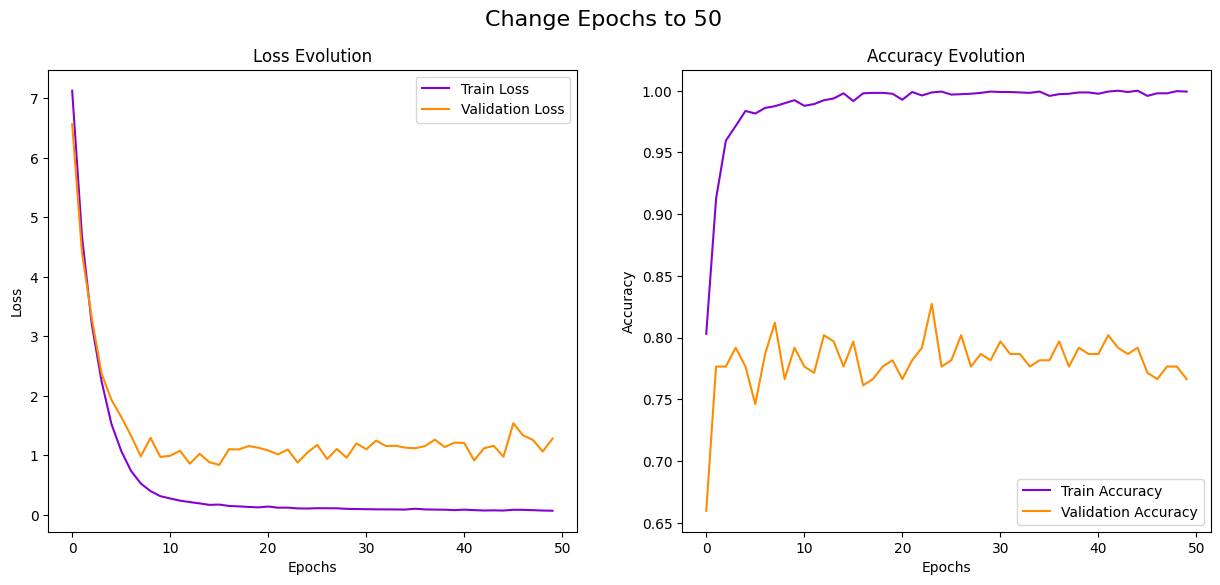

In [17]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,input_shape = img_shape, pooling= 'max')
model_op1 = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_op2.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_op2.summary()

# Model training
Epochs = 50
start_time = time.time()
history_op2 = model_op2.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")


#Graph Visualistion 
history_dict_op2 = history_op2.history
val_loss_op2 = history_dict_op2['val_loss']
train_loss_op2 = history_dict_op2['loss']
val_accuracy_op2 = history_dict_op2['val_accuracy']
train_accuracy_op2 = history_dict_op2['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op2, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op2, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op2, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op2, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Change Epochs to 50  ', fontsize=16)

plt.show()

# Change Epochs to 25

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_4 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 16:01:22.310405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 100s 205ms/step - loss: 7.0939 - accuracy: 0.7937 - val_loss: 6.5115 - val_accuracy: 0.7157
Epoch 2/25
192/192 [==============================] - 37s 192ms/step - loss: 4.7179 - accuracy: 0.9226 - val_loss: 4.4990 - val_accuracy: 0.7462
Epoch 3/25
192/192 [==============================] - 37s 193ms/step - loss: 3.3463 - accuracy: 0.9564 - val_loss: 3.6367 - val_accuracy: 0.7513
Epoch 4/25
192/192 [==============================] - 37s 192ms/step - loss: 2.3654 - accuracy: 0.9725 - val_loss: 2.5200 - val_accuracy: 0.7817
Epoch 5/25
192/192 [==============================] - 37s 193ms/step - loss: 1.6736 - accuracy: 0.9798 - val_loss: 2.1109 - val_accuracy: 0.7614
Epoch 6/25
192/192 [==============================] - 37s 192ms/step - loss: 1.1782 - accuracy: 0.9850 - val_loss: 1.8337 - val_accuracy: 0.7513
Epoch 7/25
192/192 [==============================] - 37s 193ms/step - loss: 0.8463 - accuracy: 0.9840 - val_loss: 1.3594 - val_accuracy: 0.

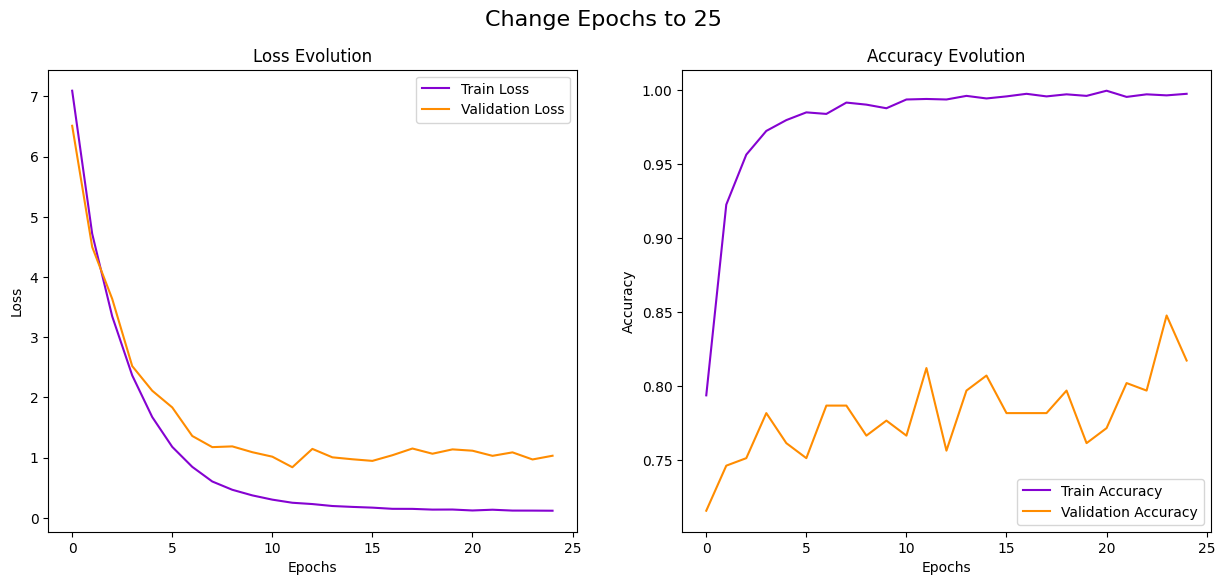

In [18]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,input_shape = img_shape, pooling= 'max')

model_op3 = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_op3.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_op3.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op3 = model_op3.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")


#Graph Visualistion 
history_dict_op3 = history_op3.history
val_loss_op3 = history_dict_op3['val_loss']
train_loss_op3 = history_dict_op3['loss']
val_accuracy_op3 = history_dict_op3['val_accuracy']
train_accuracy_op3 = history_dict_op3['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op3, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op3, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op3, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op3, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Change Epochs to 25  ', fontsize=16)

plt.show()

# Change Dropout to 0.5

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_5 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               393472    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 16:17:56.651927: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 101s 205ms/step - loss: 7.4829 - accuracy: 0.7690 - val_loss: 6.6023 - val_accuracy: 0.6751
Epoch 2/25
192/192 [==============================] - 37s 193ms/step - loss: 5.2129 - accuracy: 0.9111 - val_loss: 5.1832 - val_accuracy: 0.7310
Epoch 3/25
192/192 [==============================] - 37s 192ms/step - loss: 3.7904 - accuracy: 0.9564 - val_loss: 4.1010 - val_accuracy: 0.7005
Epoch 4/25
192/192 [==============================] - 37s 193ms/step - loss: 2.8025 - accuracy: 0.9659 - val_loss: 3.0273 - val_accuracy: 0.7462
Epoch 5/25
192/192 [==============================] - 37s 193ms/step - loss: 2.0713 - accuracy: 0.9756 - val_loss: 2.2612 - val_accuracy: 0.7919
Epoch 6/25
192/192 [==============================] - 37s 193ms/step - loss: 1.5476 - accuracy: 0.9798 - val_loss: 2.2603 - val_accuracy: 0.7208
Epoch 7/25
192/192 [==============================] - 37s 193ms/step - loss: 1.1311 - accuracy: 0.9868 - val_loss: 1.7751 - val_accuracy: 0.

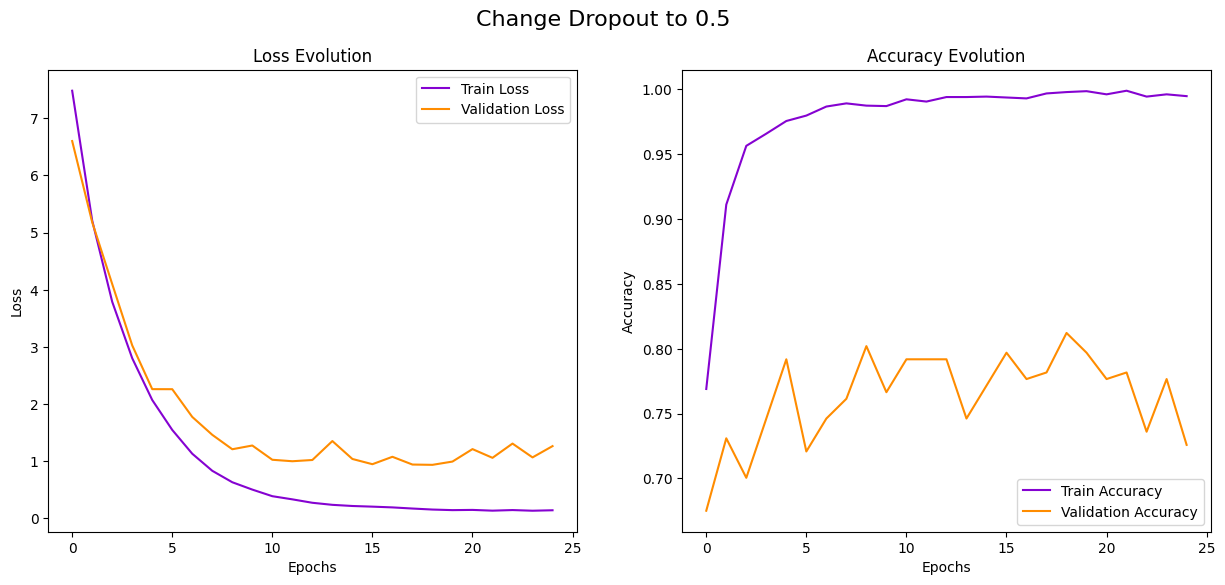

In [19]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,input_shape = img_shape, pooling= 'max')

model_op4 = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.5 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_op4.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_op4.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op4 = model_op4.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")


#Graph Visualistion 
history_dict_op4 = history_op4.history
val_loss_op4 = history_dict_op4['val_loss']
train_loss_op4 = history_dict_op4['loss']
val_accuracy_op4 = history_dict_op4['val_accuracy']
train_accuracy_op4= history_dict_op4['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op4, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op4, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op4, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op4, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Change Dropout to 0.5  ', fontsize=16)

plt.show()

# Change L2 Regularaztion to 0.08

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-04-01 16:39:34.902835: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 105s 213ms/step - loss: 17.7933 - accuracy: 0.7983 - val_loss: 8.3102 - val_accuracy: 0.7208
Epoch 2/25
192/192 [==============================] - 37s 191ms/step - loss: 4.4063 - accuracy: 0.9334 - val_loss: 2.6552 - val_accuracy: 0.8020
Epoch 3/25
192/192 [==============================] - 37s 191ms/step - loss: 1.3846 - accuracy: 0.9585 - val_loss: 1.3724 - val_accuracy: 0.7665
Epoch 4/25
192/192 [==============================] - 37s 192ms/step - loss: 0.5905 - accuracy: 0.9742 - val_loss: 1.0024 - val_accuracy: 0.7614
Epoch 5/25
192/192 [==============================] - 37s 191ms/step - loss: 0.3570 - accuracy: 0.9840 - val_loss: 0.7421 - val_accuracy: 0.8173
Epoch 6/25
192/192 [==============================] - 37s 191ms/step - loss: 0.2866 - accuracy: 0.9875 - val_loss: 0.7086 - val_accuracy: 0.7970
Epoch 7/25
192/192 [==============================] - 37s 191ms/step - loss: 0.2809 - accuracy: 0.9829 - val_loss: 1.1451 - val_accuracy: 0

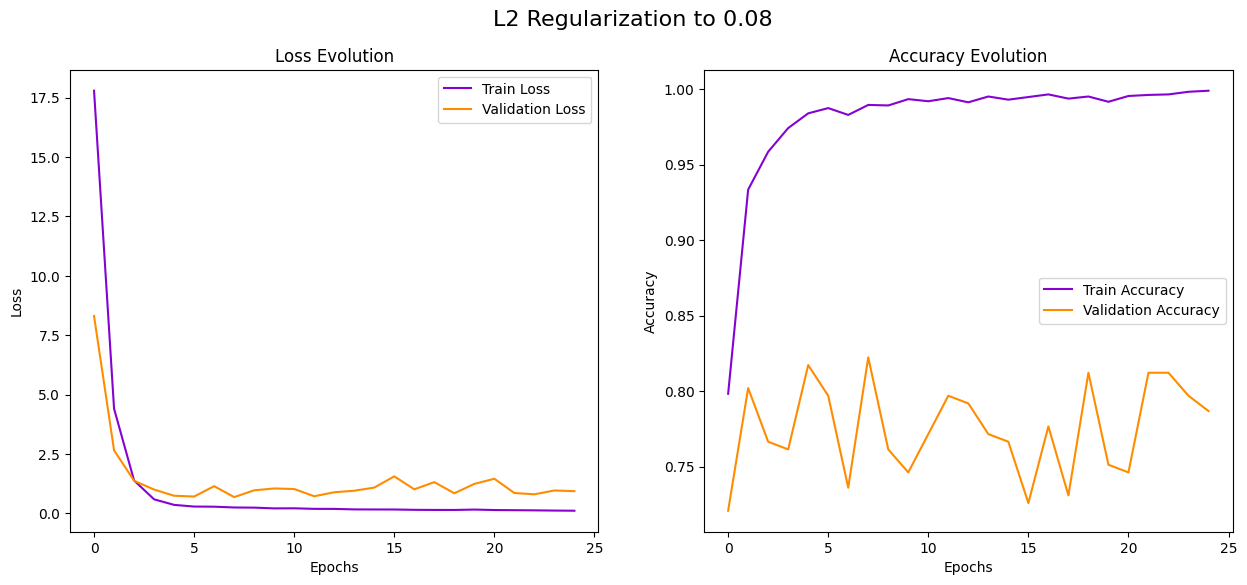

In [11]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model_op10 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.08), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

# optimizer
model_op10.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_op10.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op10 = model_op10.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                              validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_op10 = history_op10.history
val_loss_op10 = history_dict_op10['val_loss']
train_loss_op10 = history_dict_op10['loss']
val_accuracy_op10 = history_dict_op10['val_accuracy']
train_accuracy_op10 = history_dict_op10['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op10, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op10, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op10, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op10, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('L2 Regularization to 0.08', fontsize=16)

plt.show()


# Change Activation Function to tanH

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_2 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               393472    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-04-01 16:56:10.172353: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 99s 209ms/step - loss: 7.2448 - accuracy: 0.8021 - val_loss: 6.4746 - val_accuracy: 0.7005
Epoch 2/25
192/192 [==============================] - 38s 197ms/step - loss: 4.7806 - accuracy: 0.9105 - val_loss: 4.4178 - val_accuracy: 0.8173
Epoch 3/25
192/192 [==============================] - 38s 197ms/step - loss: 3.2548 - accuracy: 0.9585 - val_loss: 3.2051 - val_accuracy: 0.7868
Epoch 4/25
192/192 [==============================] - 38s 197ms/step - loss: 2.3342 - accuracy: 0.9767 - val_loss: 2.4405 - val_accuracy: 0.8020
Epoch 5/25
192/192 [==============================] - 38s 196ms/step - loss: 1.7258 - accuracy: 0.9819 - val_loss: 1.9964 - val_accuracy: 0.7766
Epoch 6/25
192/192 [==============================] - 38s 196ms/step - loss: 1.3076 - accuracy: 0.9815 - val_loss: 1.5530 - val_accuracy: 0.8223
Epoch 7/25
192/192 [==============================] - 38s 196ms/step - loss: 1.0101 - accuracy: 0.9861 - val_loss: 1.4167 - val_accuracy: 0.7

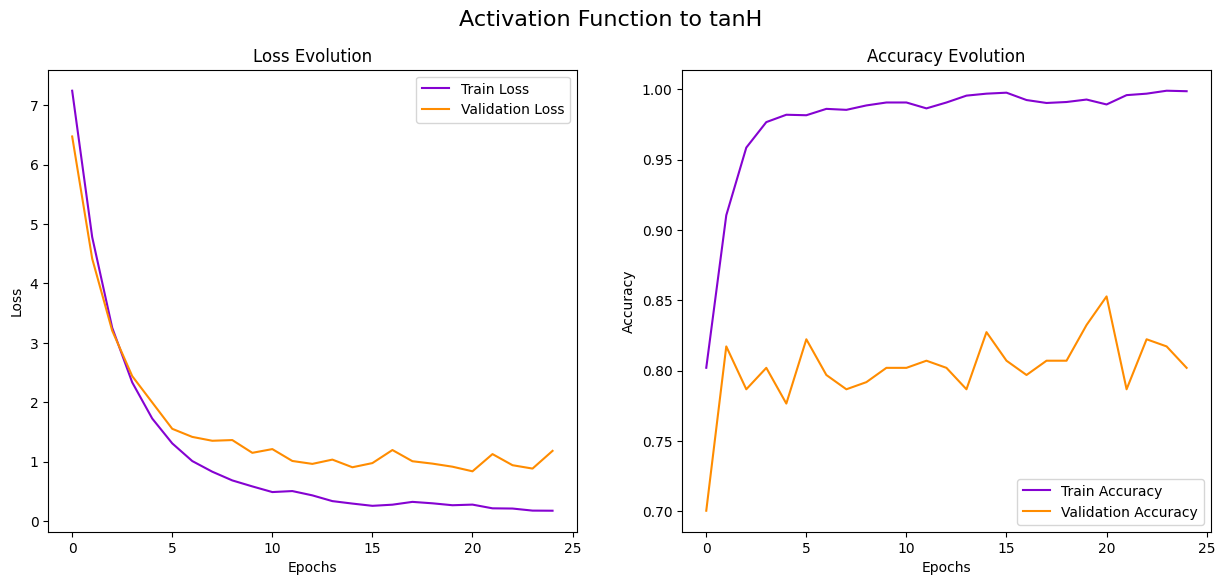

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model_op11 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='tanh'),  # Changed activation function to tanh
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

# optimizer
model_op11.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_op11.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op11 = model_op11.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                              validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_op11 = history_op11.history
val_loss_op11 = history_dict_op11['val_loss']
train_loss_op11 = history_dict_op11['loss']
val_accuracy_op11 = history_dict_op11['val_accuracy']
train_accuracy_op11 = history_dict_op11['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op11, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op11, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op11, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op11, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Activation Function to tanH', fontsize=16)

plt.show()

# Change L2 Regularaztion to 0.02

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_3 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               393472    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 19:04:11.406233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 98s 205ms/step - loss: 8.3369 - accuracy: 0.7902 - val_loss: 7.5766 - val_accuracy: 0.6447
Epoch 2/25
192/192 [==============================] - 37s 192ms/step - loss: 5.1579 - accuracy: 0.9247 - val_loss: 4.8390 - val_accuracy: 0.7310
Epoch 3/25
192/192 [==============================] - 37s 192ms/step - loss: 3.3315 - accuracy: 0.9585 - val_loss: 3.3571 - val_accuracy: 0.7259
Epoch 4/25
192/192 [==============================] - 37s 192ms/step - loss: 2.1508 - accuracy: 0.9697 - val_loss: 2.2222 - val_accuracy: 0.7716
Epoch 5/25
192/192 [==============================] - 37s 192ms/step - loss: 1.3660 - accuracy: 0.9805 - val_loss: 1.6942 - val_accuracy: 0.7716
Epoch 6/25
192/192 [==============================] - 37s 193ms/step - loss: 0.9001 - accuracy: 0.9822 - val_loss: 1.4594 - val_accuracy: 0.7919
Epoch 7/25
192/192 [==============================] - 37s 192ms/step - loss: 0.6193 - accuracy: 0.9847 - val_loss: 1.3146 - val_accuracy: 0.7

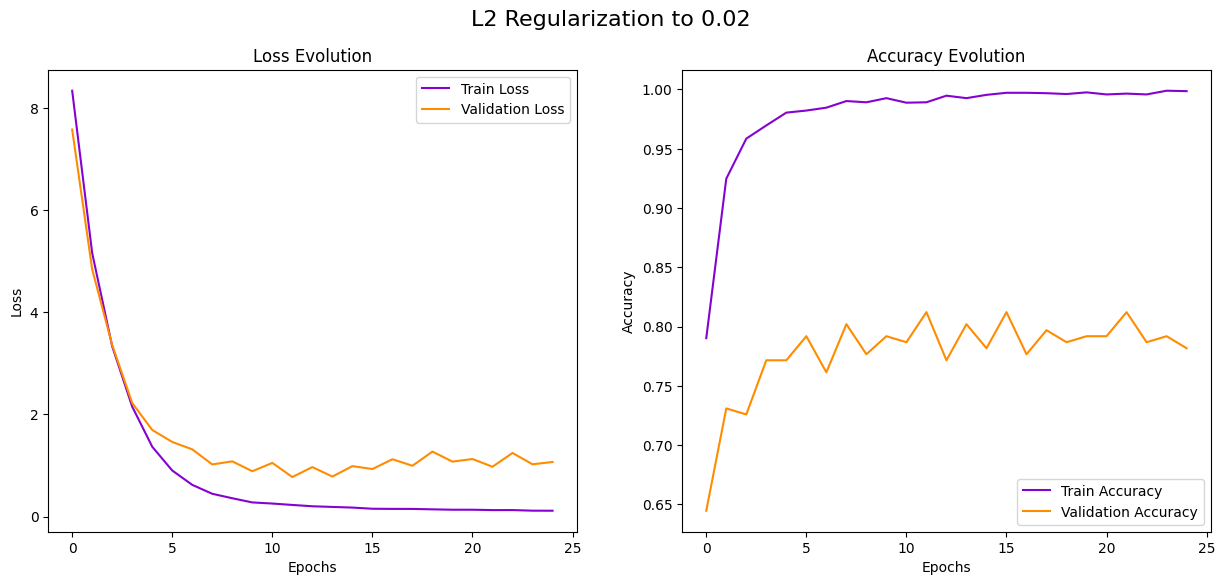

In [24]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,input_shape = img_shape, pooling= 'max')

model_op5 = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.02) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_op5.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_op5.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op5 = model_op5.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")


#Graph Visualistion 
history_dict_op5 = history_op5.history
val_loss_op5 = history_dict_op5['val_loss']
train_loss_op5 = history_dict_op5['loss']
val_accuracy_op5 = history_dict_op5['val_accuracy']
train_accuracy_op5 = history_dict_op5['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op5, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op5, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op5, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op5, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('L2 Regularization to 0.02', fontsize=16)

plt.show()


In [ ]:
#r רק שנשנה אא, היחס אימון מבחן
#valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

# Change Batch Size to 32

In [11]:
img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size_02 = 32 # This defines a variable called batch_size that stores an integer, 32. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen_02 = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size_02)

valid_gen_02 = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size_02)

test_gen_02 = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size_02)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


In [12]:
gen_dict = train_gen_02.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen_02)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' , input_shape = img_shape, pooling= 'max')

model_BS = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_BS.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_BS.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non

In [13]:
# Model training
Epochs = 25
start_time = time.time()
history_BS = model_BS.fit(x= train_gen_02 , epochs = Epochs , verbose = 1 , validation_data = valid_gen_02 ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

Epoch 1/25


2024-04-03 09:09:41.439065: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


90/90 [==============================] - 116s 535ms/step - loss: 7.3265 - accuracy: 0.7920 - val_loss: 6.6720 - val_accuracy: 0.7208
Epoch 2/25
90/90 [==============================] - 41s 444ms/step - loss: 5.0797 - accuracy: 0.9390 - val_loss: 5.1035 - val_accuracy: 0.7107
Epoch 3/25
90/90 [==============================] - 50s 561ms/step - loss: 3.7498 - accuracy: 0.9728 - val_loss: 4.1673 - val_accuracy: 0.7005
Epoch 4/25
90/90 [==============================] - 42s 469ms/step - loss: 2.8289 - accuracy: 0.9847 - val_loss: 3.3641 - val_accuracy: 0.7056
Epoch 5/25
90/90 [==============================] - 35s 387ms/step - loss: 2.1454 - accuracy: 0.9902 - val_loss: 2.7510 - val_accuracy: 0.7513
Epoch 6/25
90/90 [==============================] - 35s 386ms/step - loss: 1.6329 - accuracy: 0.9923 - val_loss: 2.3509 - val_accuracy: 0.7513
Epoch 7/25
90/90 [==============================] - 35s 386ms/step - loss: 1.2250 - accuracy: 0.9962 - val_loss: 1.8406 - val_accuracy: 0.7614
Epoch 8/2

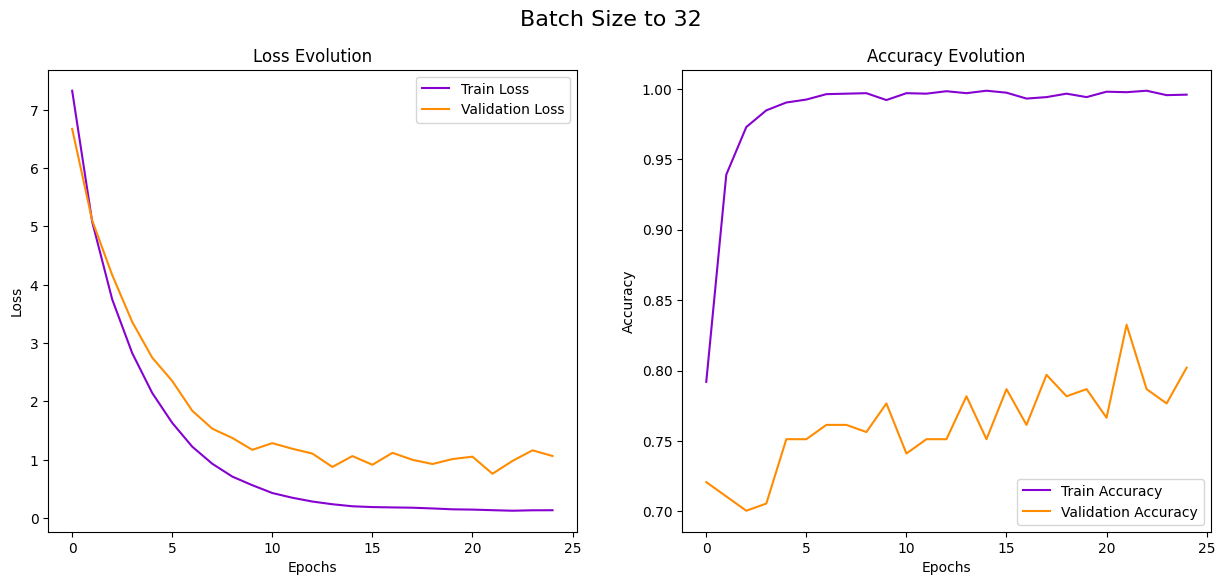

In [14]:
# Graph Visualistion 
history_dict_BS = history_BS.history
val_loss_BS = history_dict_BS['val_loss']
train_loss_BS = history_dict_BS['loss']
val_accuracy_BS = history_dict_BS['val_accuracy']
train_accuracy_BS = history_dict_BS['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_BS, label='Train Loss', color='#8502d1')
plt.plot(val_loss_BS, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_BS, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_BS, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Batch Size to 32', fontsize=16)

plt.show()

# Change Image Size to 512

In [11]:
img_size = (512 ,512)#This defines a variable called img_size that stores a tuple of two integers, 512 and 512. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 15. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen_03 = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen_03 = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen_03 = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


In [12]:
gen_dict = train_gen_03.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen_03)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' , input_shape = img_shape, pooling= 'max')

model_IS = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_IS.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_IS.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non

In [13]:
# Model training
Epochs = 25
start_time = time.time()
history_IS = model_IS.fit(x= train_gen_03 , epochs = Epochs , verbose = 1 , validation_data = valid_gen_03 ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

Epoch 1/25


2024-04-02 20:26:29.726642: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 245s 946ms/step - loss: 7.0202 - accuracy: 0.7986 - val_loss: 6.5547 - val_accuracy: 0.7005
Epoch 2/25
192/192 [==============================] - 177s 919ms/step - loss: 4.5751 - accuracy: 0.9390 - val_loss: 4.6860 - val_accuracy: 0.6802
Epoch 3/25
192/192 [==============================] - 177s 919ms/step - loss: 3.1830 - accuracy: 0.9676 - val_loss: 3.2987 - val_accuracy: 0.7563
Epoch 4/25
192/192 [==============================] - 177s 924ms/step - loss: 2.2433 - accuracy: 0.9711 - val_loss: 2.6255 - val_accuracy: 0.7614
Epoch 5/25
192/192 [==============================] - 178s 925ms/step - loss: 1.5481 - accuracy: 0.9843 - val_loss: 1.9975 - val_accuracy: 0.7513
Epoch 6/25
192/192 [==============================] - 177s 924ms/step - loss: 1.0902 - accuracy: 0.9847 - val_loss: 1.7014 - val_accuracy: 0.7716
Epoch 7/25
192/192 [==============================] - 178s 925ms/step - loss: 0.7625 - accuracy: 0.9913 - val_loss: 1.4476 - val_accura

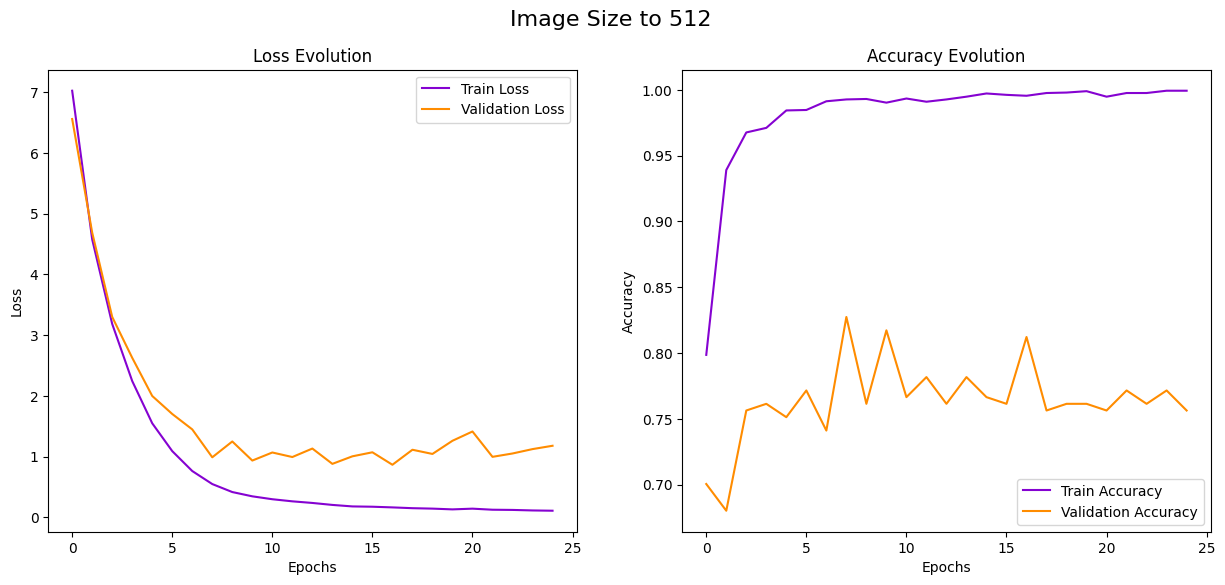

In [14]:
# Graph Visualistion 
history_dict_IS = history_IS.history
val_loss_IS = history_dict_IS['val_loss']
train_loss_IS = history_dict_IS['loss']
val_accuracy_IS = history_dict_IS['val_accuracy']
train_accuracy_IS = history_dict_IS['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_IS, label='Train Loss', color='#8502d1')
plt.plot(val_loss_IS, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_IS, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_IS, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Image Size to 512', fontsize=16)

plt.show()


# Change Dense to 128

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 10,986,931
Trainable params: 10,896,556
Non

2024-03-31 18:27:00.576896: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 107s 221ms/step - loss: 4.3315 - accuracy: 0.7847 - val_loss: 4.3473 - val_accuracy: 0.7157
Epoch 2/25
192/192 [==============================] - 37s 192ms/step - loss: 3.0807 - accuracy: 0.9035 - val_loss: 3.5097 - val_accuracy: 0.7766
Epoch 3/25
192/192 [==============================] - 37s 193ms/step - loss: 2.3122 - accuracy: 0.9484 - val_loss: 2.5390 - val_accuracy: 0.7716
Epoch 4/25
192/192 [==============================] - 37s 192ms/step - loss: 1.7456 - accuracy: 0.9693 - val_loss: 2.3110 - val_accuracy: 0.7462
Epoch 5/25
192/192 [==============================] - 37s 192ms/step - loss: 1.3046 - accuracy: 0.9815 - val_loss: 1.8880 - val_accuracy: 0.7817
Epoch 6/25
192/192 [==============================] - 37s 193ms/step - loss: 0.9908 - accuracy: 0.9815 - val_loss: 1.7169 - val_accuracy: 0.7411
Epoch 7/25
192/192 [==============================] - 37s 193ms/step - loss: 0.7434 - accuracy: 0.9829 - val_loss: 1.4554 - val_accuracy: 0.

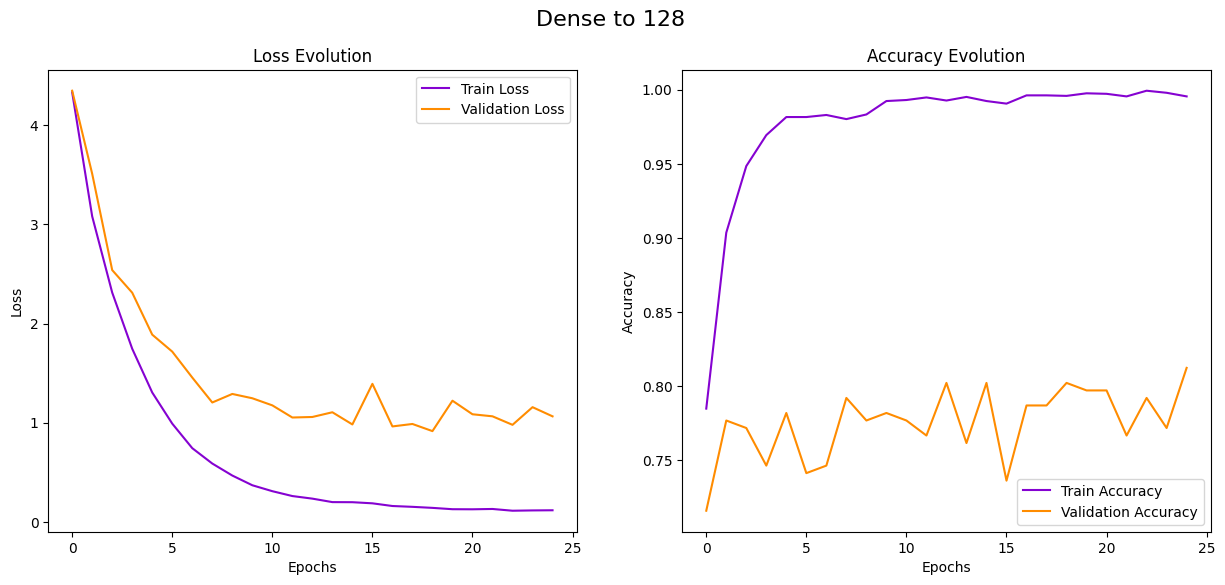

In [21]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model_op6 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(128, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

# Optimizer
model_op6.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_op6.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op6 = model_op6.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                            validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")


# Graph Visualization
history_dict_op6 = history_op6.history
val_loss_op6 = history_dict_op6['val_loss']
train_loss_op6 = history_dict_op6['loss']
val_accuracy_op6 = history_dict_op6['val_accuracy']
train_accuracy_op6 = history_dict_op6['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op6, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op6, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op6, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op6, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Dense to 128', fontsize=16)

plt.show()


# Change L1 Regularization to 0.02

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_4 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 19:20:41.932739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 98s 204ms/step - loss: 7.9568 - accuracy: 0.7634 - val_loss: 6.7516 - val_accuracy: 0.6447
Epoch 2/25
192/192 [==============================] - 37s 191ms/step - loss: 5.3652 - accuracy: 0.8756 - val_loss: 5.1240 - val_accuracy: 0.7259
Epoch 3/25
192/192 [==============================] - 37s 191ms/step - loss: 4.0477 - accuracy: 0.9247 - val_loss: 3.9283 - val_accuracy: 0.7766
Epoch 4/25
192/192 [==============================] - 37s 192ms/step - loss: 3.0982 - accuracy: 0.9449 - val_loss: 3.1659 - val_accuracy: 0.7817
Epoch 5/25
192/192 [==============================] - 37s 192ms/step - loss: 2.3389 - accuracy: 0.9690 - val_loss: 2.5476 - val_accuracy: 0.7919
Epoch 6/25
192/192 [==============================] - 37s 191ms/step - loss: 1.8049 - accuracy: 0.9669 - val_loss: 2.0798 - val_accuracy: 0.7868
Epoch 7/25
192/192 [==============================] - 37s 192ms/step - loss: 1.3514 - accuracy: 0.9882 - val_loss: 1.6300 - val_accuracy: 0.7

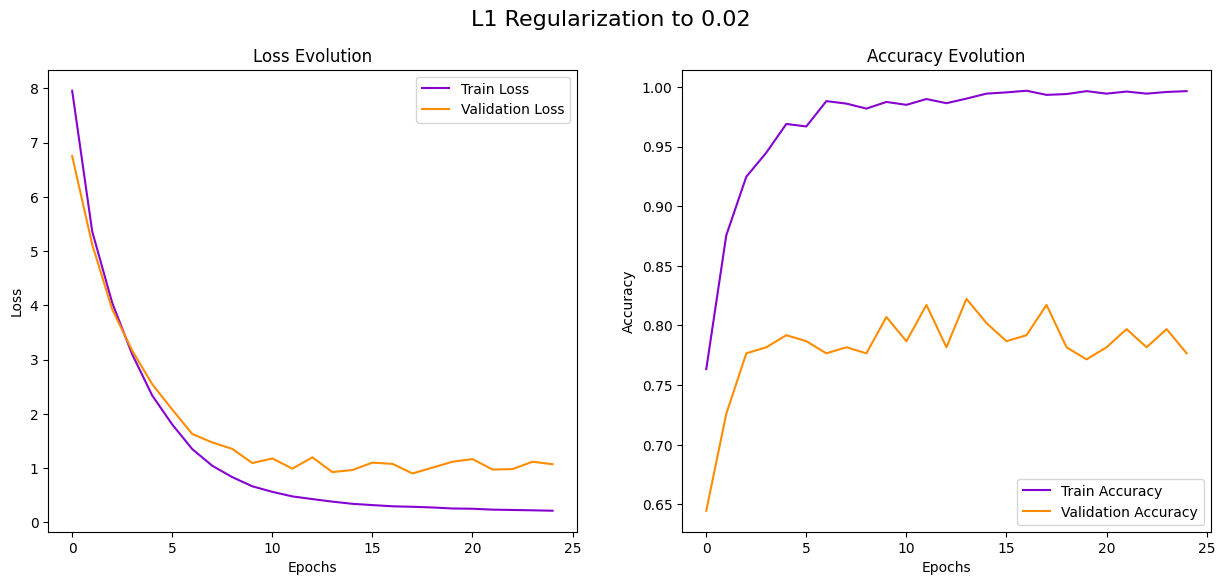

In [25]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model_op7 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.02),
          bias_regularizer=regularizers.l1(0.02), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

# optimizer
model_op7.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_op7.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op7 = model_op7.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                            validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_op7 = history_op7.history
val_loss_op7 = history_dict_op7['val_loss']
train_loss_op7 = history_dict_op7['loss']
val_accuracy_op7 = history_dict_op7['val_accuracy']
train_accuracy_op7 = history_dict_op7['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op7, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op7, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op7, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op7, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('L1 Regularization to 0.02', fontsize=16)

plt.show()


# Change L1 Regularization to 0.001

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_5 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 256)               393472    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 19:37:14.184197: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


192/192 [==============================] - 97s 204ms/step - loss: 6.6432 - accuracy: 0.7836 - val_loss: 6.1539 - val_accuracy: 0.7107
Epoch 2/25
192/192 [==============================] - 37s 192ms/step - loss: 4.4691 - accuracy: 0.9164 - val_loss: 4.3687 - val_accuracy: 0.8020
Epoch 3/25
192/192 [==============================] - 37s 193ms/step - loss: 3.1435 - accuracy: 0.9568 - val_loss: 3.4148 - val_accuracy: 0.7817
Epoch 4/25
192/192 [==============================] - 37s 192ms/step - loss: 2.2037 - accuracy: 0.9679 - val_loss: 2.9915 - val_accuracy: 0.7310
Epoch 5/25
192/192 [==============================] - 37s 192ms/step - loss: 1.5266 - accuracy: 0.9787 - val_loss: 2.0139 - val_accuracy: 0.7970
Epoch 6/25
192/192 [==============================] - 37s 191ms/step - loss: 1.0444 - accuracy: 0.9829 - val_loss: 1.6084 - val_accuracy: 0.7919
Epoch 7/25
192/192 [==============================] - 37s 191ms/step - loss: 0.7101 - accuracy: 0.9882 - val_loss: 1.3729 - val_accuracy: 0.8

<function matplotlib.pyplot.show(close=None, block=None)>

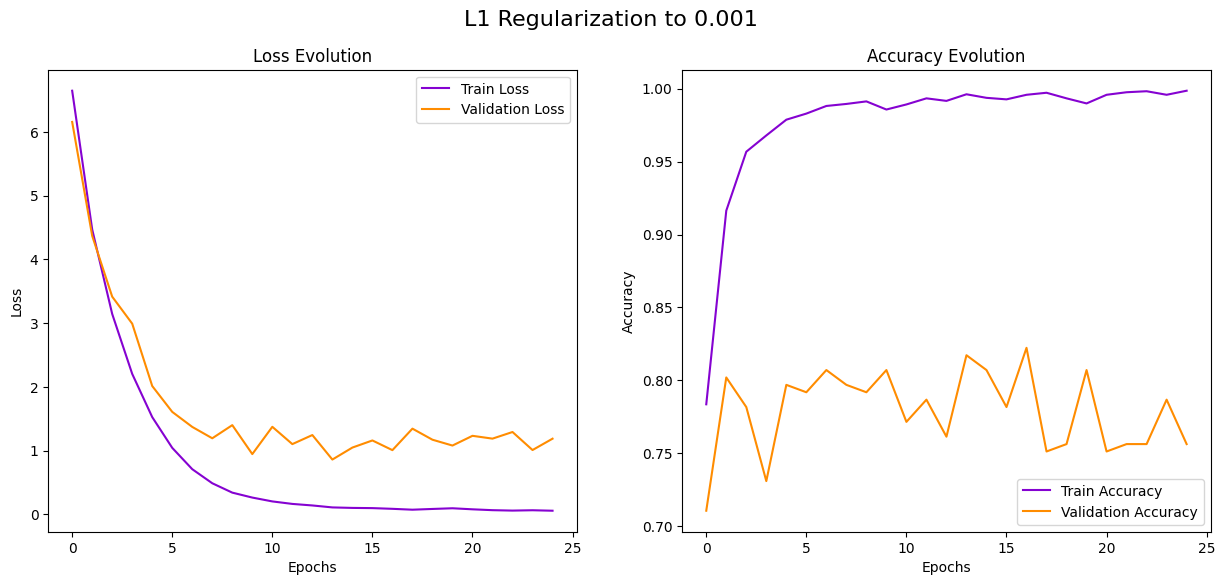

In [26]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model_op8 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.001),
          bias_regularizer=regularizers.l1(0.001), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

# optimizer
model_op8.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_op8.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op8 = model_op8.fit(x=train_gen, epochs=Epochs, verbose=1, validation_data=valid_gen,
                            validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_op8 = history_op8.history
val_loss_op8 = history_dict_op8['val_loss']
train_loss_op8 = history_dict_op8['loss']
val_accuracy_op8 = history_dict_op8['val_accuracy']
train_accuracy_op8 = history_dict_op8['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op8, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op8, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op8, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op8, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('L1 Regularization to 0.001', fontsize=16)

plt.show


# Change Test-Train Ratio to 80/20

In [33]:
valid_04 , train_04 = train_test_split(train_df , train_size = 0.2 , shuffle = True , random_state= 42)

img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen_04 = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen_04= ImageDataGenerator()

train_gen_04 = tr_gen.flow_from_dataframe(train_04 , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen_04 = ts_gen.flow_from_dataframe(valid_04 , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen_04 = ts_gen.flow_from_dataframe(test_df , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2296 validated image filenames belonging to 4 classes.
Found 574 validated image filenames belonging to 4 classes.
Found 394 validated image filenames belonging to 4 classes.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_8 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_16 (Dense)            (None, 256)               393472    
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-03-31 20:27:30.408232: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


154/154 [==============================] - 94s 218ms/step - loss: 7.4468 - accuracy: 0.7787 - val_loss: 6.1705 - val_accuracy: 0.8641
Epoch 2/25
154/154 [==============================] - 31s 199ms/step - loss: 5.2485 - accuracy: 0.9103 - val_loss: 4.5063 - val_accuracy: 0.9303
Epoch 3/25
154/154 [==============================] - 31s 199ms/step - loss: 3.8328 - accuracy: 0.9578 - val_loss: 3.3538 - val_accuracy: 0.9408
Epoch 4/25
154/154 [==============================] - 31s 199ms/step - loss: 2.8562 - accuracy: 0.9686 - val_loss: 2.7095 - val_accuracy: 0.8815
Epoch 5/25
154/154 [==============================] - 31s 200ms/step - loss: 2.1134 - accuracy: 0.9795 - val_loss: 1.7984 - val_accuracy: 0.9704
Epoch 6/25
154/154 [==============================] - 31s 200ms/step - loss: 1.5968 - accuracy: 0.9760 - val_loss: 1.3576 - val_accuracy: 0.9756
Epoch 7/25
154/154 [==============================] - 31s 199ms/step - loss: 1.1907 - accuracy: 0.9821 - val_loss: 1.0300 - val_accuracy: 0.9

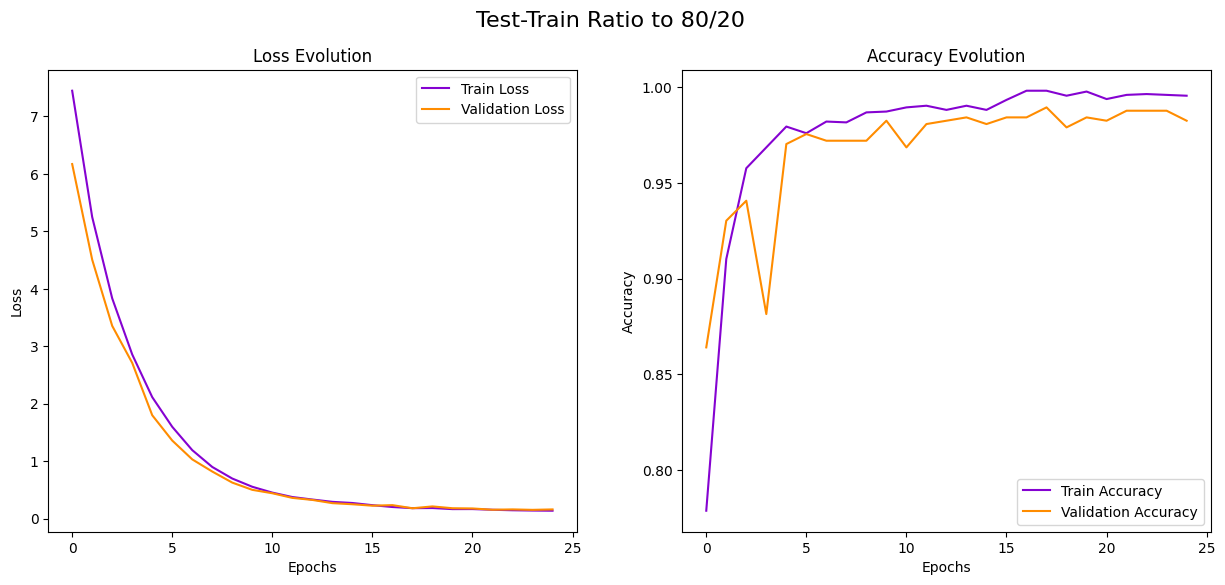

In [34]:
gen_dict = train_gen_04.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen_04)
img_shape = (img_size[0], img_size[1], 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

model_op9 = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.4, seed=75),
    Dense(num_class, activation='softmax')
])

# optimizer
model_op9.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_op9.summary()

# Model training
Epochs = 25
start_time = time.time()
history_op9 = model_op9.fit(x=train_gen_04, epochs=Epochs, verbose=1, validation_data=valid_gen_04,
                            validation_steps=None, shuffle=False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

# Graph Visualization
history_dict_op9 = history_op9.history
val_loss_op9 = history_dict_op9['val_loss']
train_loss_op9 = history_dict_op9['loss']
val_accuracy_op9 = history_dict_op9['val_accuracy']
train_accuracy_op9 = history_dict_op9['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op9, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op9, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op9, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op9, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Test-Train Ratio to 80/20', fontsize=16)

plt.show()


# ניסיון חוזר של יחס אימון מבחן

In [30]:
train_data_path = '/kaggle/input/brain-tumor-classification-mri/Training'

filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

test_data_path = '/kaggle/input/brain-tumor-classification-mri/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

# איחוד בניהם
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.info()

class_counts = combined_df['label'].value_counts()
print(class_counts)

# מספרי הדוגמאות לכל מחלקה
meningioma_tumor = combined_df['label'].value_counts()['meningioma_tumor']
glioma_tumor = combined_df['label'].value_counts()['glioma_tumor']
pituitary_tumor = combined_df['label'].value_counts()['pituitary_tumor']
no_tumor = combined_df['label'].value_counts()['no_tumor']

print("Meningioma Tumor:", meningioma_tumor)
print("Glioma Tumor:", glioma_tumor)
print("Pituitary Tumor:", pituitary_tumor)
print("No Tumor:", no_tumor)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3264 entries, 0 to 3263
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  3264 non-null   object
 1   label      3264 non-null   object
dtypes: object(2)
memory usage: 51.1+ KB
label
meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            500
Name: count, dtype: int64
Meningioma Tumor: 937
Glioma Tumor: 926
Pituitary Tumor: 901
No Tumor: 500


In [39]:
from sklearn.utils import shuffle
combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df = shuffle(combined_df, random_state=101)

train_PE , test_PE = train_test_split(combined_df , test_size = 0.2 , shuffle = True , random_state= 42)

valid_PE , train_PE = train_test_split(train_PE , train_size = 0.2 , shuffle = True , random_state= 42)

In [40]:
print(len(train_PE))
print(len(test_PE))
print(len(vlid_PE))


2089
653
130


522
2612
130


ValueError: x must be 1D

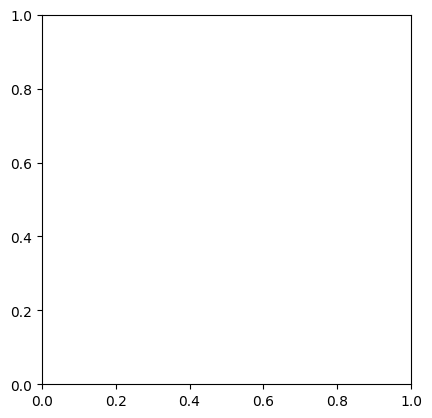

In [24]:
print(len(train_PE))
print(len(test_PE))
print(len(vlid_PE))

total = train_PE + test_PE + valid_PE
train_percent = (train_PE / total) * 100
test_percent = (test_PE / total) * 100
valid_percent = (valid_PE / total) * 100

# שרטוט גרף עוגה
import matplotlib.pyplot as plt

labels = ['Train', 'Test', 'Valid']
sizes = [train_percent, test_percent, valid_percent]
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Data')
plt.show()

In [41]:
img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen_PE = tr_gen.flow_from_dataframe(train_PE , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen_PE = ts_gen.flow_from_dataframe(valid_PE , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen_PE = ts_gen.flow_from_dataframe(test_PE , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2089 validated image filenames belonging to 4 classes.
Found 522 validated image filenames belonging to 4 classes.
Found 653 validated image filenames belonging to 4 classes.


In [45]:
model_PE = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_PE.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_PE.summary()

# Model training
Epochs = 50
start_time = time.time()
history_PE = model_PE.fit(x= train_gen_PE , epochs = Epochs , verbose = 1 , validation_data = valid_gen_PE ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_6 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 256)               393472    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

2024-04-01 18:13:23.010906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - 87s 216ms/step - loss: 4.4825 - accuracy: 0.9828 - val_loss: 3.1521 - val_accuracy: 0.9866
Epoch 2/50
140/140 [==============================] - 28s 200ms/step - loss: 2.4732 - accuracy: 0.9871 - val_loss: 2.0914 - val_accuracy: 0.9847
Epoch 3/50
140/140 [==============================] - 28s 199ms/step - loss: 1.8197 - accuracy: 0.9947 - val_loss: 1.5931 - val_accuracy: 0.9923
Epoch 4/50
140/140 [==============================] - 28s 200ms/step - loss: 1.3977 - accuracy: 0.9971 - val_loss: 1.2373 - val_accuracy: 0.9943
Epoch 5/50
140/140 [==============================] - 28s 199ms/step - loss: 1.1340 - accuracy: 0.9947 - val_loss: 1.0263 - val_accuracy: 0.9923
Epoch 6/50
140/140 [==============================] - 28s 199ms/step - loss: 0.8981 - accuracy: 0.9976 - val_loss: 0.9281 - val_accuracy: 0.9655
Epoch 7/50
140/140 [==============================] - 28s 198ms/step - loss: 0.7935 - accuracy: 0.9928 - val_loss: 0.6981 - val_accuracy: 0.9

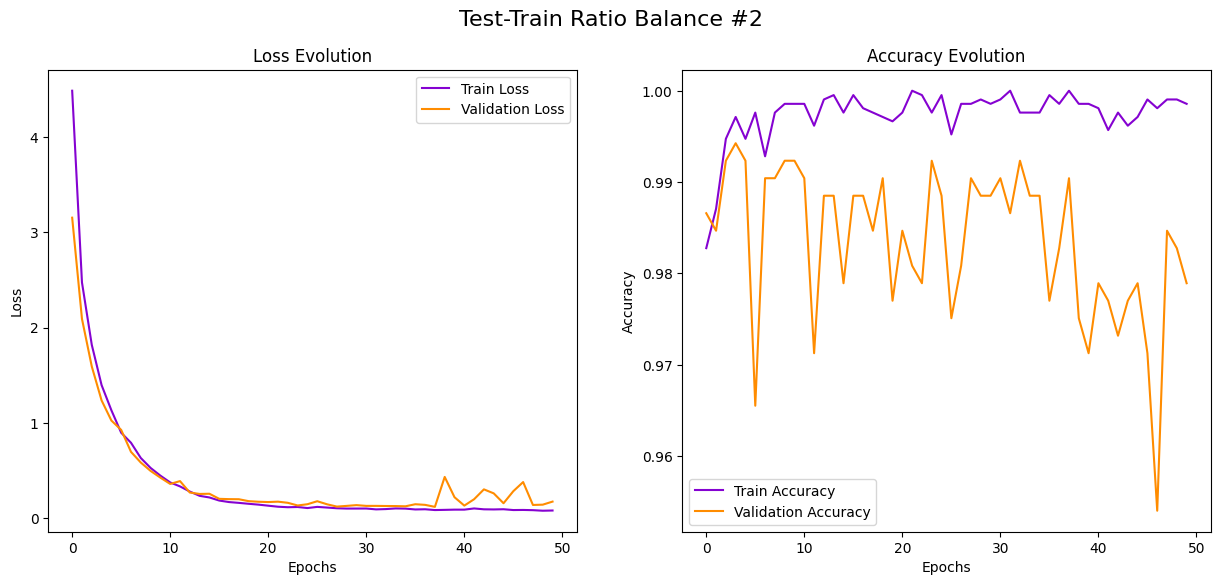

In [46]:
history_dict_PE = history_PE.history
val_loss_PE = history_dict_PE['val_loss']
train_loss_PE = history_dict_PE['loss']
val_accuracy_PE = history_dict_PE['val_accuracy']
train_accuracy_PE = history_dict_PE['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_PE, label='Train Loss', color='#8502d1')
plt.plot(val_loss_PE, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_PE, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_PE, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Test-Train Ratio Balance #2', fontsize=16)

plt.show()